<a href="https://colab.research.google.com/github/Ariqueeezz/Personal_Data_Science_Projects/blob/main/ML_BankTransaction/Submission_Akhir_BMLP_Klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
import joblib

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_csv("/content/drive/MyDrive/dataset/data_clustering_inverse.csv")
df.drop(["TransactionAmount_binned", 'TransactionDuration_binned'], axis=1, inplace=True)
df.head()

,TransactionAmount,TransactionType,Location,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,Target
0,14.09,Debit,San Diego,ATM,70.0,Doctor,81.0,1.0,5112.21,Muda Efisien
1,376.24,Debit,Houston,ATM,68.0,Doctor,141.0,1.0,13758.91,Penabung
2,126.29,Debit,Mesa,Online,19.0,Student,56.0,1.0,1122.35,Konsumtif
3,184.50,Debit,Raleigh,Online,26.0,Student,25.0,1.0,8569.06,Muda Efisien
4,13.45,Credit,Atlanta,Online,45.0,Student,198.0,1.0,7429.40,Penabung


In [9]:
X = df.drop(["Target"], axis=1)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# 1. Hitung frekuensi HANYA dari data latih
train_loc_freq = X_train['Location'].value_counts(normalize=True)

# 2. Terapkan (Map) nilai tersebut ke data latih DAN data uji
X_train['Location_freq'] = X_train['Location'].map(train_loc_freq)
X_test['Location_freq'] = X_test['Location'].map(train_loc_freq)

# 3. Handle jika ada lokasi di X_test yang tidak ada di X_train
X_test['Location_freq'] = X_test['Location_freq'].fillna(0)

# 4. Hapus kolom asli
X_train.drop('Location', axis=1, inplace=True)
X_test.drop('Location', axis=1, inplace=True)

# ***Exploratory Data Analysis***

<Axes: xlabel='Target'>

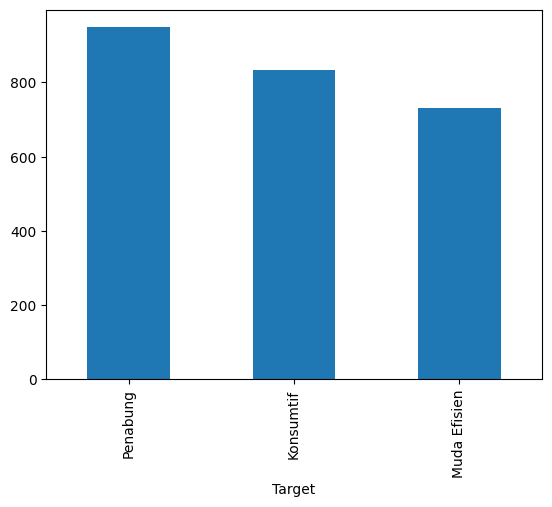

In [11]:
df['Target'].value_counts().plot(kind='bar')

In [12]:
target_mapping = {'Muda Efisien': 0, 'Penabung': 1, 'Konsumtif':2}
df['Target'] = df['Target'].map(target_mapping)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

<Axes: >

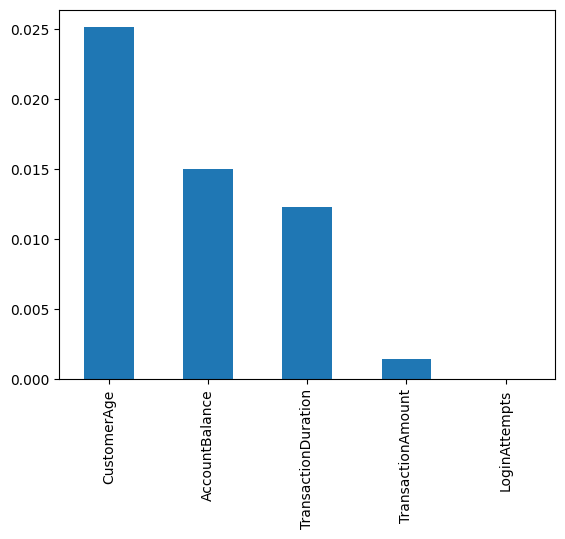

In [13]:
target_corr = df[numerical_features].corr()['Target'].abs().sort_values(ascending=False)
target_corr[1:].plot(kind='bar')

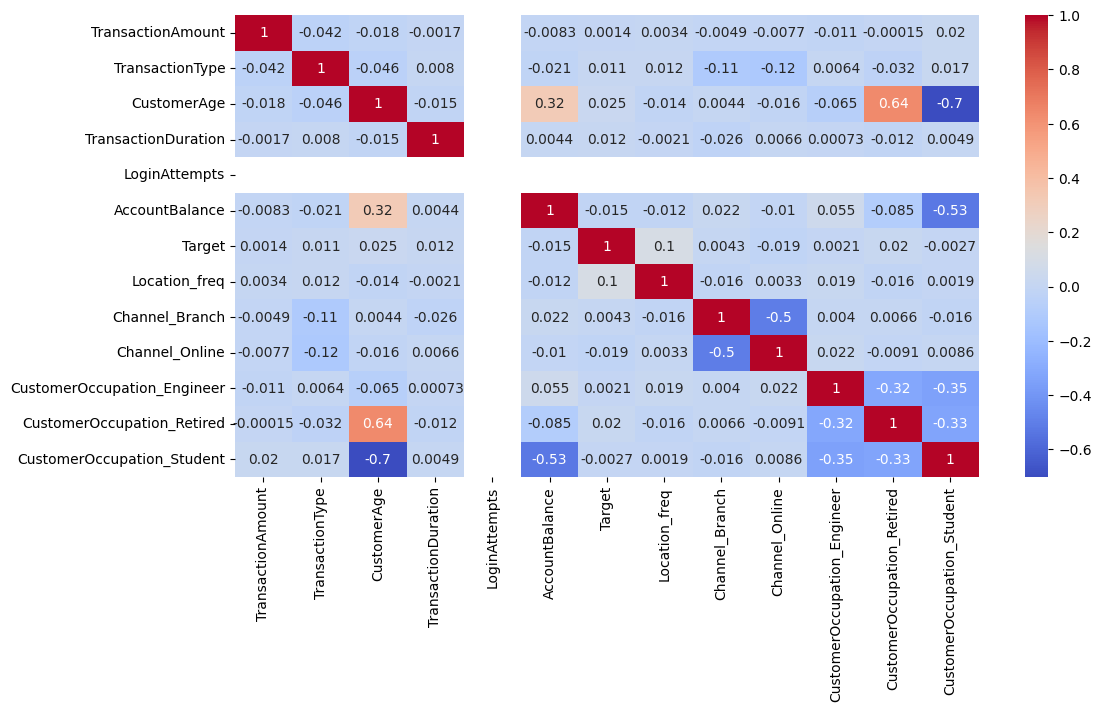

In [14]:
location_freq = df['Location'].value_counts(normalize=True)
df['Location_freq'] = df['Location'].map(location_freq)
df.drop('Location', axis=1, inplace=True)

df = pd.get_dummies(df, columns=['Channel', 'CustomerOccupation'], drop_first=True)

le = LabelEncoder()
df['TransactionType'] = le.fit_transform(df['TransactionType'])

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

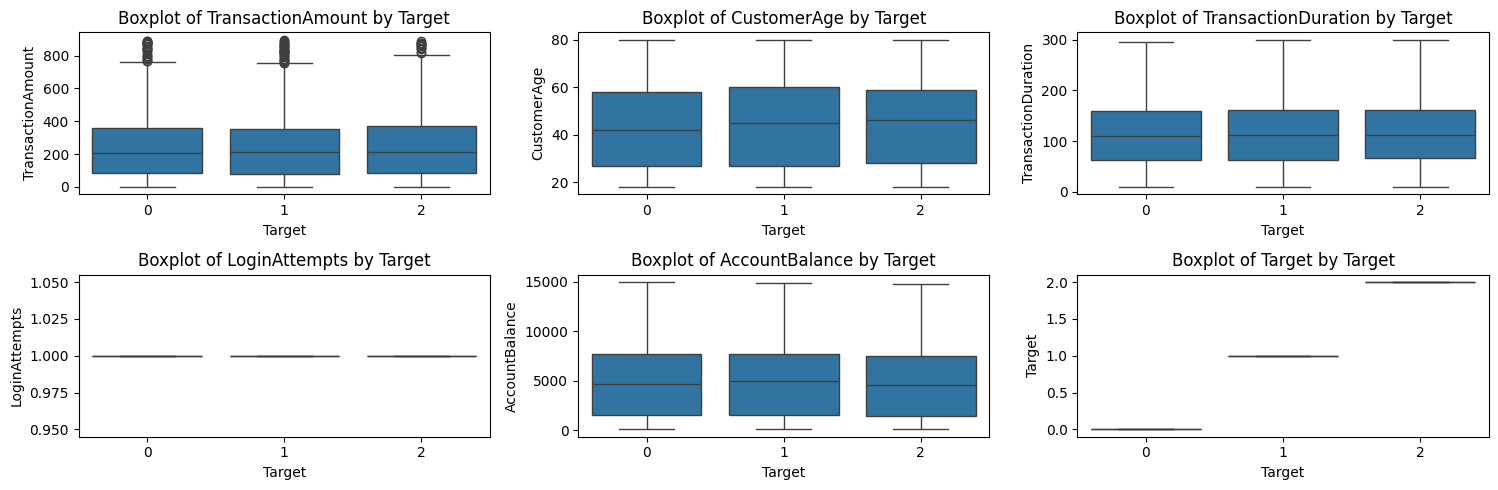

In [15]:
n_vars = len(numerical_features)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Target', y=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} by Target')

plt.tight_layout()
plt.show()

# ***Model Selection***

In [16]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

In [17]:
X_train[categorical_features].head()

,TransactionType,Channel,CustomerOccupation
1446,Debit,ATM,Engineer
2102,Credit,Online,Doctor
1990,Debit,Online,Student
2401,Debit,Online,Retired
1427,Debit,ATM,Student


Cross-Validation Score 1: 0.39800995024875624
Cross-Validation Score 2: 0.38308457711442784
Cross-Validation Score 3: 0.3582089552238806
Cross-Validation Score 4: 0.39303482587064675
Cross-Validation Score 5: 0.42039800995024873
--------------------------------------------------
Classification Report for KNN:
              precision    recall  f1-score   support

   Konsumtif       0.39      0.52      0.44       179
Muda Efisien       0.36      0.32      0.33       152
    Penabung       0.44      0.33      0.37       172

    accuracy                           0.39       503
   macro avg       0.39      0.39      0.38       503
weighted avg       0.40      0.39      0.39       503

--------------------------------------------------
F1 Score for KNN: 0.3867648663853408
--------------------------------------------------


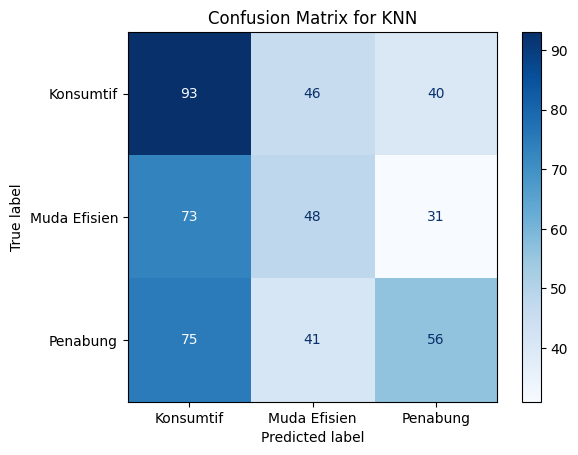

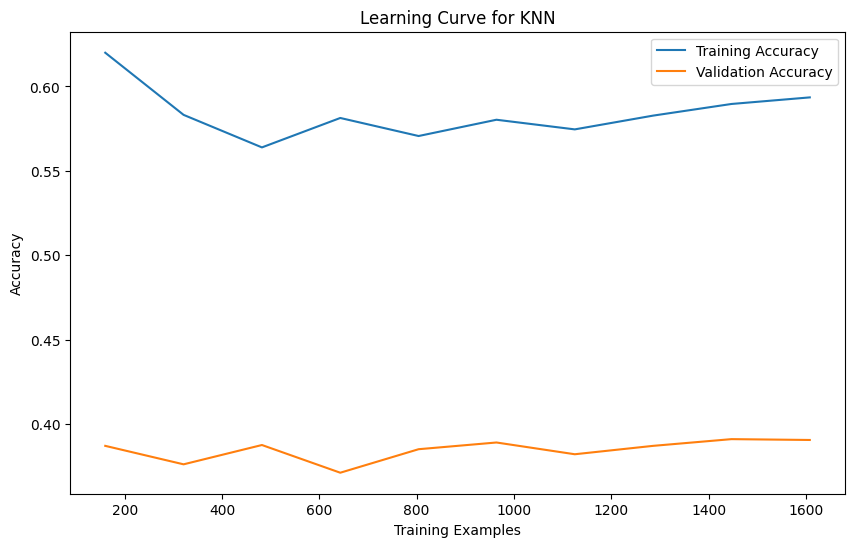

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['TransactionAmount', 'CustomerAge', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'Location_freq'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['TransactionType', 'Channel', 'CustomerOccupation'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())]) F1 Score : 0.3867648663853408
Cross-Validation Score 1: 0.6691542288557214
Cross-Validation Score 2: 0.6666666666666666
Cross-Validation Score 3: 0.6243781094527363
Cross-Validation Score 4: 0.6417910447761194
Cross-Validation Score 5: 0.6791044776119403
--------------------------------------------------
Classification Report for Decision Tree:
          

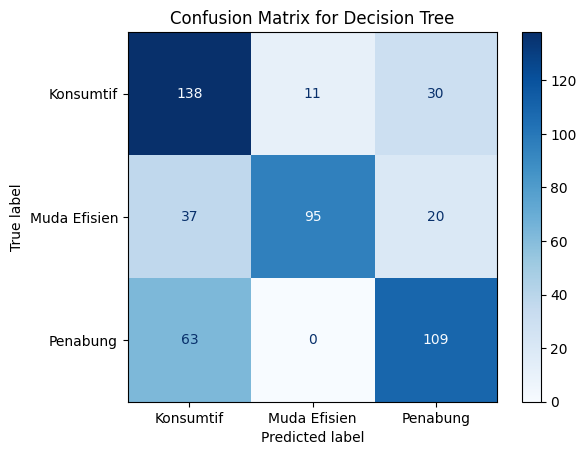

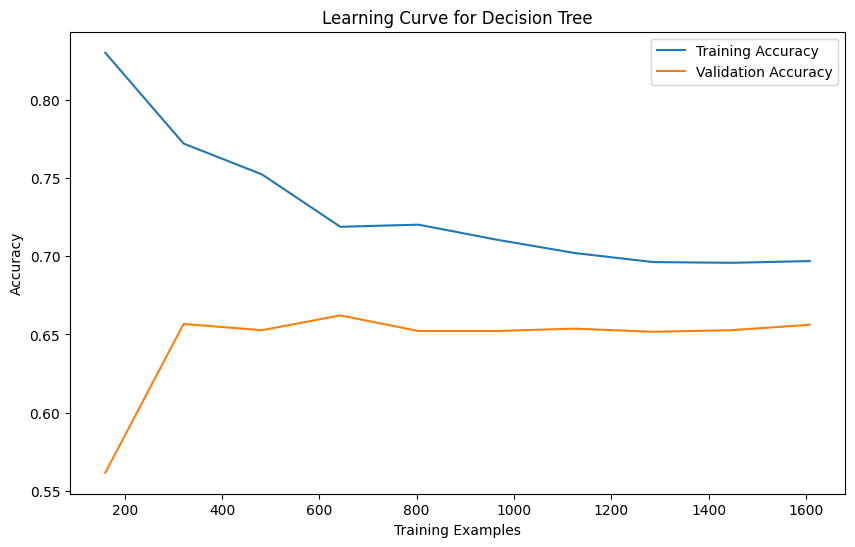

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['TransactionAmount', 'CustomerAge', 'TransactionDuration',
       'LoginAttempts', 'AccountBalance', 'Location_freq'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['TransactionType', 'Channel', 'CustomerOccupation'], dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))]) F1 Score : 0.6832878159192455


In [35]:
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

best_model = None
best_f1_score = 0

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    for i, score in enumerate(cv_scores):
        print(f"Cross-Validation Score {i+1}: {score}")
    print("-" * 50)

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

    f1score = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score for {model_name}: {f1score}")
    print("-" * 50)

    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


    if f1score > best_f1_score:
        best_f1_score = f1score
        best_model = pipeline
    print(best_model, "F1 Score :", best_f1_score)


In [36]:
joblib.dump(best_model, 'model_bank_behaviour.joblib')

['model_bank_behaviour.joblib']